# Time Sereies Analysis with Python and Darts

Darts is a Python library for user-friendly forecasting and anomaly detection on time series. It contains a variety of models, from classics such as ARIMA to deep neural networks.

The forecasting models can all be used in the same way, using `fit()` and `predict()` functions, similar to scikit-learn. The library also makes it easy to backtest models, combine the predictions of several models, and take external data into account. Darts supports both univariate and multivariate time series and models. The ML-based models can be trained on potentially large datasets containing multiple time series, and some of the models offer a rich support for probabilistic forecasting.

Darts also offers extensive anomaly detection capabilities. For instance, it is trivial to apply PyOD models on time series to obtain anomaly scores, or to wrap any of Darts forecasting or filtering models to obtain fully fledged anomaly detection models.

In [1]:
%matplotlib inline

# Linear Regression
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Darts library for time series analysis
from darts.datasets import AirPassengersDataset
from darts import TimeSeries
from darts.models import ExponentialSmoothing, NaiveSeasonal
from darts.datasets import ETTh2Dataset
from darts.ad import KMeansScorer, QuantileDetector
from darts.utils.statistics import plot_acf, check_seasonality

/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


# Time Series Object Creation

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:


In [2]:
# Read a pandas DataFrame
df = pd.read_csv("AirPassengers.csv", delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "Month", "#Passengers")

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

Fit an exponential smoothing model, and make a (probabilistic) prediction over the validation series’ duration

In [3]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=100)

Plot median, 5th and 95th percentiles of the prediction, and the validation series.

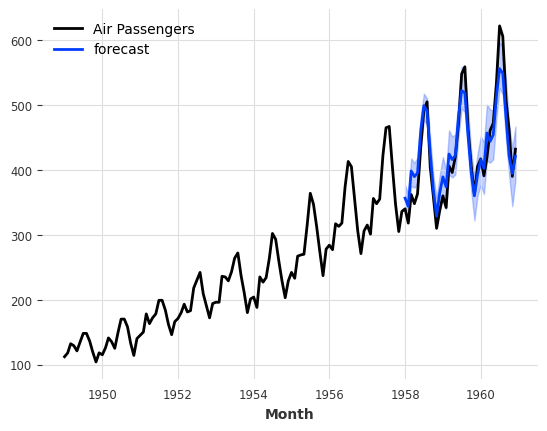

In [4]:
series.plot(label="Air Passengers")
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

# Multivariate Series Example

Load a multivariate series, trim it, keep 2 components, split train and validation sets

In [5]:
series = ETTh2Dataset().load()[:10000][["MUFL", "LULL"]]
train, val = series.split_before(0.6)

Build a K means anomaly detection model, fit it on the training set, and make a prediction on the validation set

In [6]:
scorer = KMeansScorer()
scorer.fit(train)
anomaly_scores = scorer.score(val)

# Binary Anomaly Detection

Build a binary anomaly detector and train it over train scores, then use it over validation scores to get binary anomaly classification.

In [7]:
detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anomaly = detector.detect(anomaly_scores)

# Plot Output

<Axes: xlabel='date'>

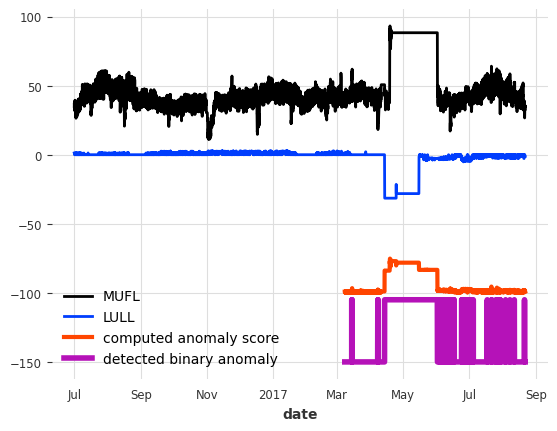

In [8]:
series.plot()
(anomaly_scores / 2.0 - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anomaly * 45 - 150).plot(label="detected binary anomaly", lw=4)

# Training forecasting models and making predictions

Play with toy models

<Axes: xlabel='Month'>

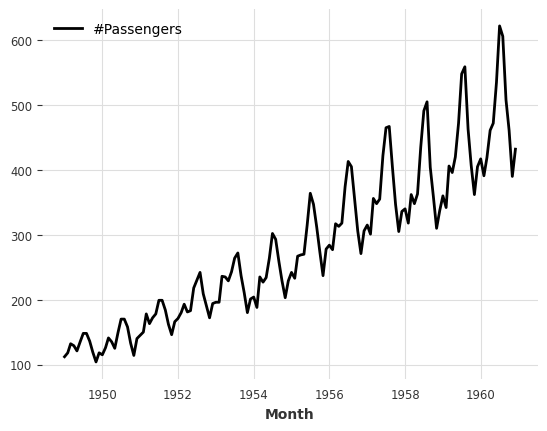

In [9]:
series = AirPassengersDataset().load()
series.plot()

<Axes: xlabel='Month'>

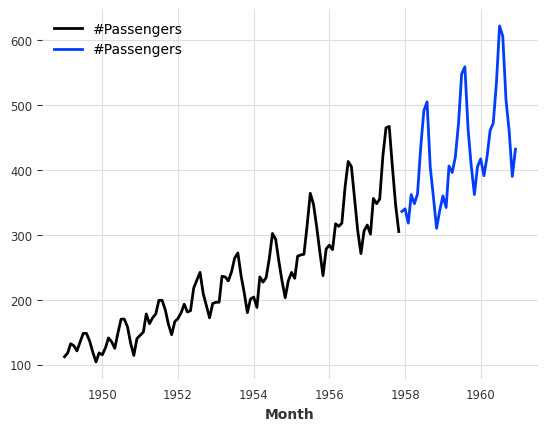

In [10]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

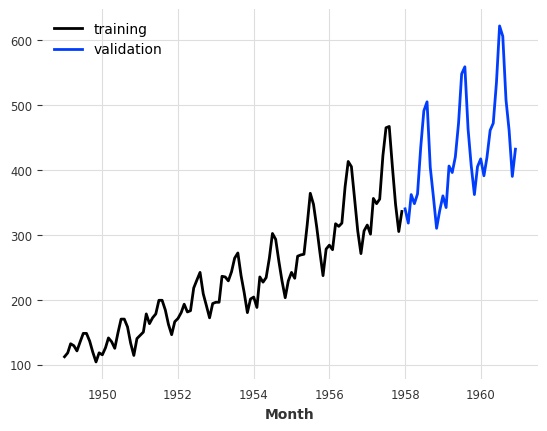

In [11]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

<Axes: xlabel='Month'>

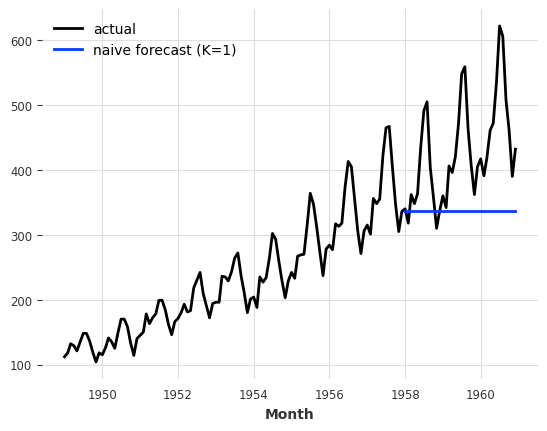

In [12]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

## Inspect Seasonality

Our model above is perhaps a bit too naive. We can already improve by exploiting the seasonality in the data. It seems quite obvious that the data has a yearly seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag m=12:

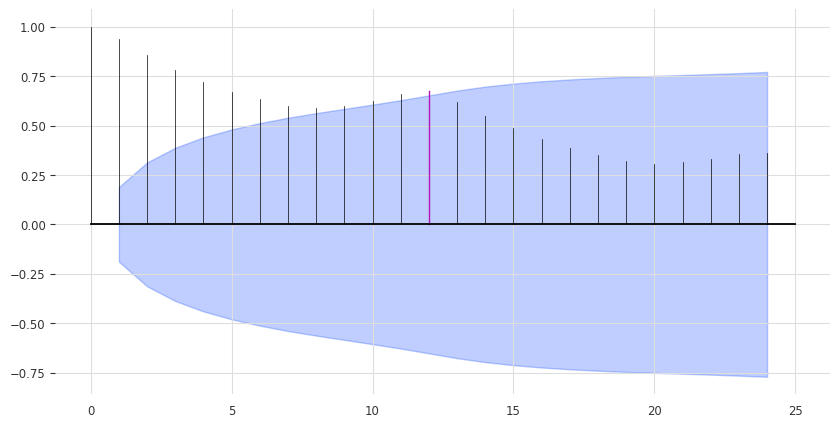

In [13]:
plot_acf(train, m=12, alpha=0.05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of . We can also run a statistical check of seasonality for each candidate period m:

<Axes: xlabel='Month'>

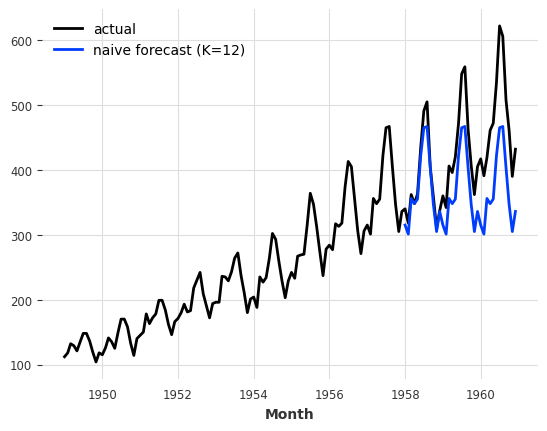

In [14]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

The trend is still missing. We then use NaiveDrift to deal with the trend.

<Axes: xlabel='Month'>

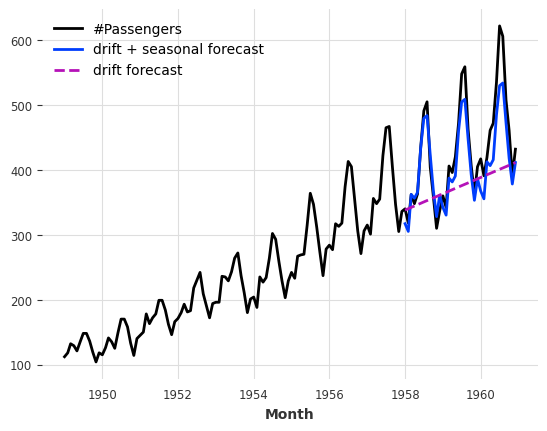

In [15]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="drift + seasonal forecast")
drift_forecast.plot(label="drift forecast", ls="--")

Mean Absolute Percentage Error (MAPE) on the validation set

In [16]:
from darts.metrics import mape

print(mape(series, combined_forecast))

5.660848396158498


# Evaluate several other models

In [17]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def evaluate_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    val.plot(label="actual")
    forecast.plot(label=str(model))
    plt.legend()
    print("model {} MAPE: {:.2f}%".format(model, mape(val, forecast)))

model ExponentialSmoothing() MAPE: 5.11%


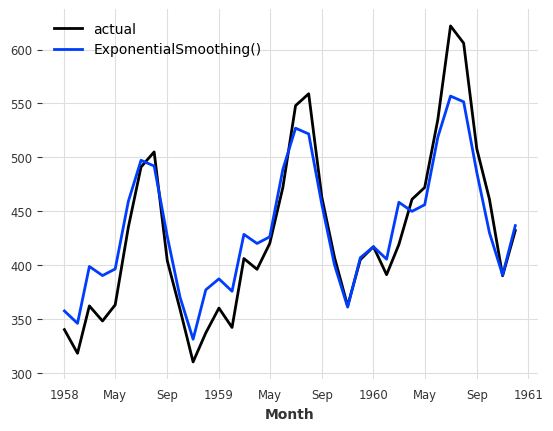

In [18]:
evaluate_model(ExponentialSmoothing())

model TBATS(season_length=12) MAPE: 12.06%


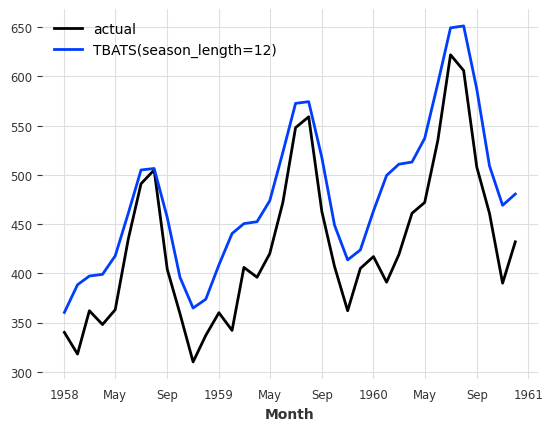

In [19]:
evaluate_model(TBATS(season_length=12))

model AutoARIMA() MAPE: 12.70%


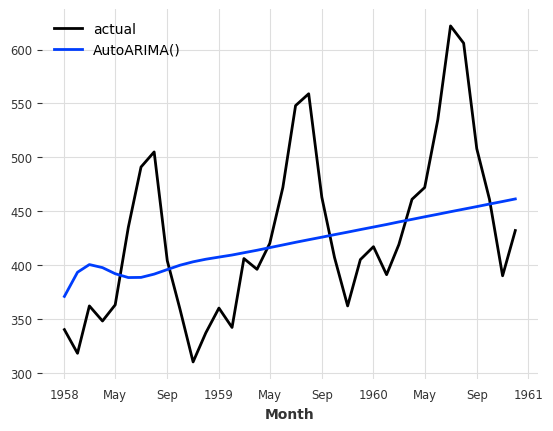

In [20]:
evaluate_model(AutoARIMA())

model Theta() MAPE: 8.15%


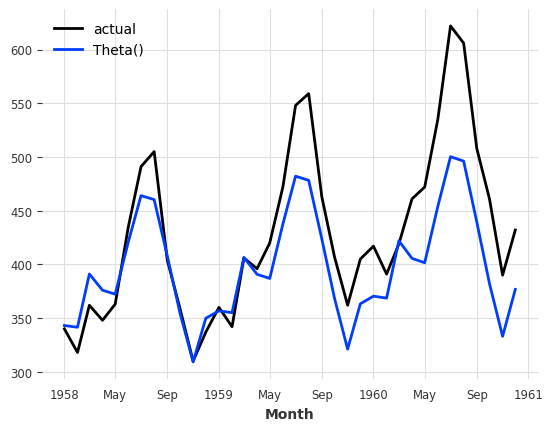

In [21]:
evaluate_model(Theta())

# Searching for Hyperparameters Using `Theta` Method

Search for the best theta parameter, by trying 50 different values

In [22]:
thetats = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetats:
    model = Theta(theta=theta)
    model.fit(train)
    forecast_theta = model.predict(len(val))
    res = mape(val, forecast_theta)
    if res < best_mape:
        best_mape = res
        best_theta = theta


In [23]:
best_theta_model = Theta(theta=best_theta)
best_theta_model.fit(train)
best_theta_forecast = best_theta_model.predict(len(val))

print("Best theta: {}, MAPE: {:.2f}%".format(best_theta, mape(val, best_theta_forecast)))

Best theta: -3.5102040816326543, MAPE: 4.40%


<Axes: xlabel='Month'>

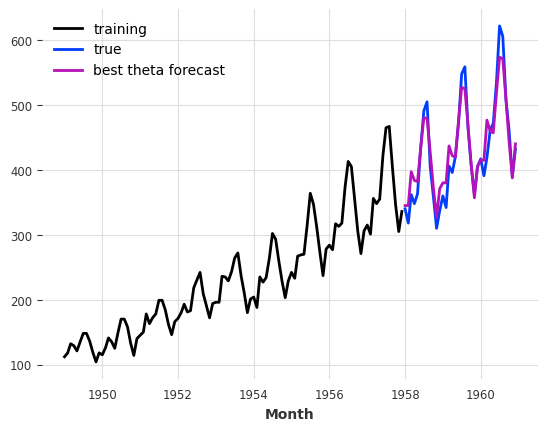

In [24]:
train.plot(label="training")
val.plot(label="true")
best_theta_forecast.plot(label="best theta forecast")

# Application using deep learning models - exampke with N-BEATS

In [25]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_scaled = scaler.fit_transform(train).astype(np.float32)
val_scaled = scaler.transform(val).astype(np.float32)

Parameters:

- input_chunk_length: this is the "lookback window" of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

- output_chunk_length: this is the "forward window" of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

In [26]:
from darts.models import NBEATSModel

model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42)

model.fit(train_scaled,epochs=100,verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true b

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

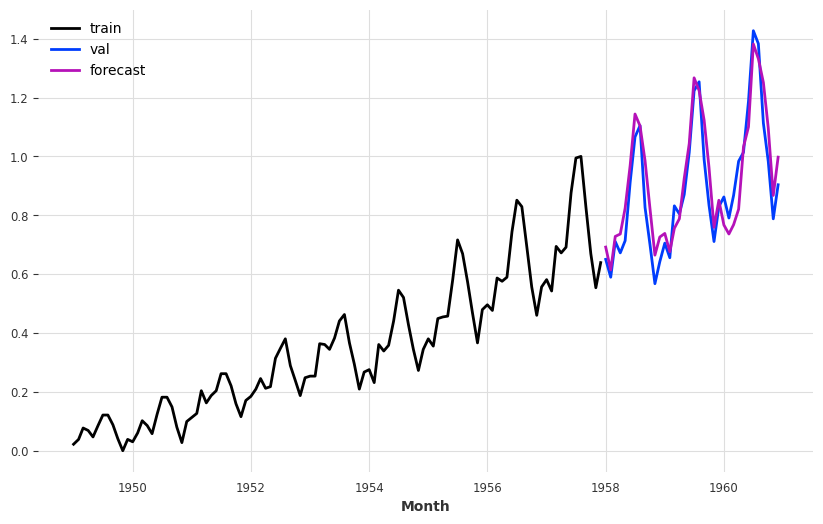

In [27]:
predict_air = model.predict(series=train_scaled, n=36)
plt.figure(figsize=(10, 6))
train_scaled.plot(label="train")
val_scaled.plot(label="val")
predict_air.plot(label="forecast")

In [28]:
encoders = {
    "datetime_attribute": {"past": ["month", "year"]},
    "transformer": Scaler()
}

In [29]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42)

model.fit(train_scaled,epochs=100,verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true b

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, add_encoders={'datetime_attribute': {'past': ['month', 'year']}, 'transformer': Scaler}, random_state=42)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

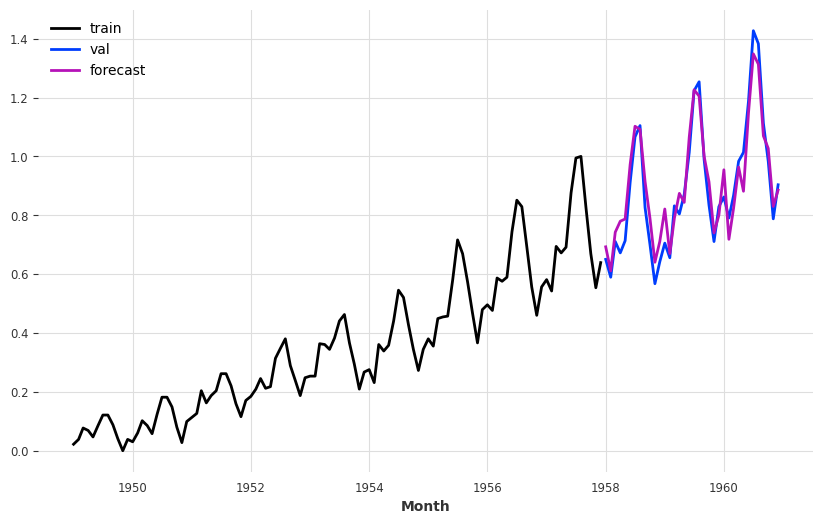

In [30]:
predict_air = model.predict(series=train_scaled, n=36)

plt.figure(figsize=(10, 6))
train_scaled.plot(label="train")
val_scaled.plot(label="val")
predict_air.plot(label="forecast")

# Regression Forecasting

In [31]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(
    lags=72,
    model=BayesianRidge()
)

model.fit([train])

RegressionModel(lags=72, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=BayesianRidge(), multi_models=True, use_static_covariates=True, random_state=None)

<Axes: xlabel='Month'>

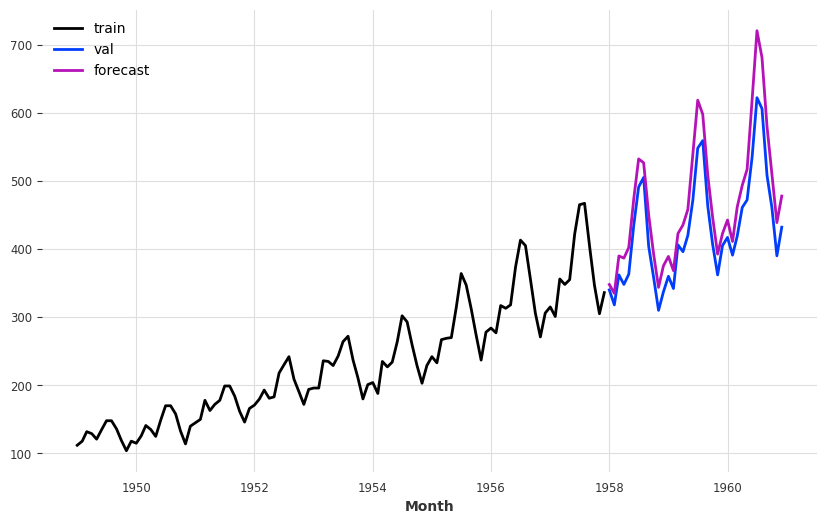

In [32]:
predict_air = model.predict(series=train, n=36)

plt.figure(figsize=(10, 6))
train.plot(label="train")
val.plot(label="val")
predict_air.plot(label="forecast")

# Probabilistic Forecasting

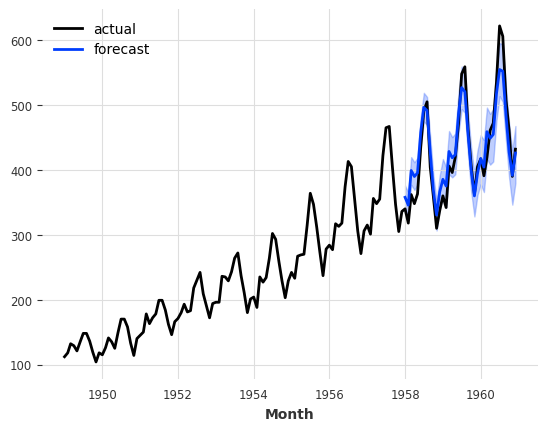

In [33]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="forecast")
plt.legend()
plt.show()

## With Neural Networks

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | eval 
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 3.4 K  | train
-------------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.013     Total estimated model params size (MB)
22        Modules in train 

Using device: cpu
Resuming training from checkpoint...
Training epochs 1 to 50


/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 50
Training epochs 51 to 100


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 100
Training epochs 101 to 150


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 150
Training epochs 151 to 200


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 200
Training epochs 201 to 250


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 250
Training epochs 251 to 300


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 300
Training epochs 301 to 350


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `TCNModel.load_weights()` to load the weights for fine-tuning.


Checkpoint saved at epoch 350
Training epochs 351 to 400


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Checkpoint saved at epoch 400


Predicting: |          | 0/? [00:00<?, ?it/s]

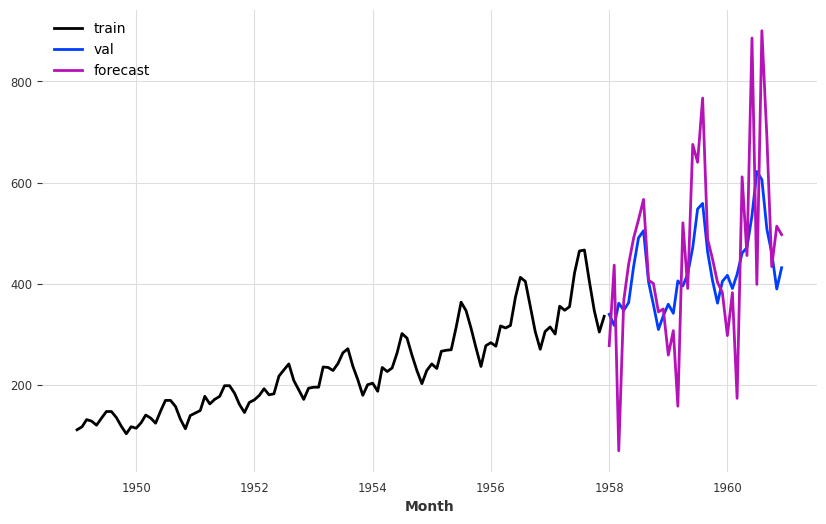

In [35]:
import os
import numpy as np
import torch
from darts import TimeSeries
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood
import matplotlib.pyplot as plt

# -----------------------------
# Device setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------------
# Ensure series are float32
# -----------------------------
train_max = train.max().values()[0]  # get scalar
train_scaled = (train / train_max).astype(np.float32)
val_scaled = (val / train_max).astype(np.float32)


# -----------------------------
# Custom LaplaceLikelihood enforcing minimum scale
# -----------------------------
class SafeLaplaceLikelihood(LaplaceLikelihood):
    def _params_from_output(self, output: torch.Tensor):
        mu, b = super()._params_from_output(output)
        b = torch.nn.functional.softplus(b) + 1e-6  # enforce strictly positive scale
        return mu, b


# -----------------------------
# Checkpoint directory
# -----------------------------
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "tcn_laplace_safe.ckpt")

# -----------------------------
# Build TCN model
# -----------------------------
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=SafeLaplaceLikelihood(),
    batch_size=8,
    num_filters=16,  # corrected parameter
    pl_trainer_kwargs={
        "accelerator": device,
        "gradient_clip_val": 1.0,
    },
)

# -----------------------------
# Resume from checkpoint if exists
# -----------------------------
if os.path.exists(checkpoint_path):
    print("Resuming training from checkpoint...")
    model = TCNModel.load(checkpoint_path)

# -----------------------------
# Train in small epoch chunks
# -----------------------------
total_epochs = 400
chunk_epochs = 50

for start_epoch in range(0, total_epochs, chunk_epochs):
    end_epoch = start_epoch + chunk_epochs
    print(f"Training epochs {start_epoch + 1} to {end_epoch}")

    model.fit(
        series=train_scaled,
        epochs=chunk_epochs,
        verbose=True,
    )

    # Save checkpoint
    model.save(checkpoint_path)
    print(f"Checkpoint saved at epoch {end_epoch}")

# -----------------------------
# Forecast
# -----------------------------
predict_scaled = model.predict(n=36, series=train_scaled, num_samples=1)
predict_air = predict_scaled * train_max  # rescale to original values

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(10, 6))
train.plot(label="train")
val.plot(label="val")
predict_air.plot(label="forecast")
plt.legend()
plt.show()

# Learning Ensemble Models

historical forecasts:   0%|          | 0/57 [00:00<?, ?it/s]

MAPE of ensemble model: 4.91%


<Axes: xlabel='Month'>

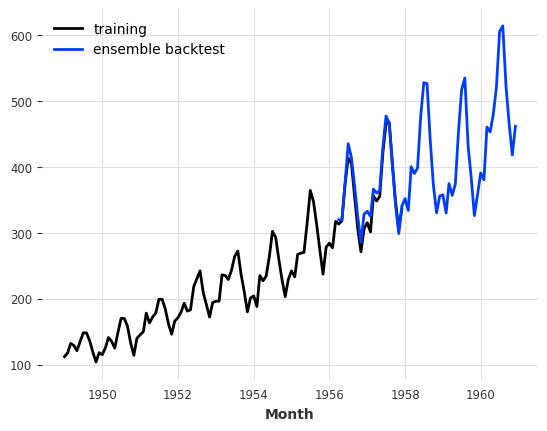

In [ ]:
from darts.models import RegressionEnsembleModel

models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=12)
backtest = ensemble_model.historical_forecasts(series, start=0.6, forecast_horizon=3, verbose=True)

print("MAPE of ensemble model: {:.2f}%".format(mape(series, backtest)))

train.plot(label="training")
backtest.plot(label="ensemble backtest")